# Dependencies

In [1]:
import os, warnings, shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tokenizers import ByteLevelBPETokenizer
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from tweet_utility_scripts import *
from tweet_utility_preprocess_roberta_scripts_aux import *
import tweet_utility_preprocess_roberta_scripts_text as preprocess_text


SEED = 0
warnings.filterwarnings("ignore")

In [2]:
import time
import requests

augment_ratio = 0.3
key = 'trnsl.1.1.20200514T223841Z.e8be2cb3b512ab50.6d2435315749e911978fe98e0a00417ddafbdcb3'

def translate(text, key, lang='en'):
    url_yandex ="https://translate.yandex.net/api/v1.5/tr.json/translate?key=%s&text=%s&lang=%s" % (key, text, lang)
    time.sleep(0.1)
    response = requests.get(url_yandex, timeout=None)
    response_data = eval(response.content.decode('utf-8'))
    text_trans = response_data['text'][0]
    
    return text_trans

def back_translate(text, selected_text, first_lang='pt'):
    text_trans, selected_text_trans = None, None
    
    text_trans_tmp = translate(text, key, lang=first_lang)
    text_trans = translate(text_trans_tmp, key)

    selected_text_trans_tmp = translate(selected_text, key, lang=first_lang)
    selected_text_trans = translate(selected_text_trans_tmp, key)

    if text_trans == None or selected_text_trans == None:
        return None, None
    elif (selected_text in text_trans.lower()) and (text != text_trans):
        return text_trans, selected_text
    elif (selected_text_trans in text_trans.lower()) and (text != text_trans):
        return text_trans, selected_text_trans
    else:
        return None, None

# Tokenizer

In [3]:
MAX_LEN = 96
base_path = '/kaggle/input/qa-transformers/roberta/'
vocab_path = base_path + 'roberta-base-vocab.json'
merges_path = base_path + 'roberta-base-merges.txt'

tokenizer = ByteLevelBPETokenizer(vocab_file=vocab_path, merges_file=merges_path, 
                                  lowercase=True, add_prefix_space=True)
tokenizer.save('./')

['./vocab.json', './merges.txt']

# Load data

In [4]:
train_df = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/train.csv')

# pre-process
train_df.dropna(inplace=True)
train_df = train_df.reset_index()
train_df.drop('index', axis=1, inplace=True)
train_df["text"] = train_df["text"].apply(lambda x: x.strip())
train_df["selected_text"] = train_df["selected_text"].apply(lambda x: x.strip())
train_df["text"] = train_df["text"].apply(lambda x: x.lower())
train_df["selected_text"] = train_df["selected_text"].apply(lambda x: x.lower())

# train_df['jaccard'] = train_df.apply(lambda x: jaccard(x['text'], x['selected_text']), axis=1)
# train_df['text_len'] = train_df['text'].apply(lambda x : len(x))
# train_df['text_wordCnt'] = train_df['text'].apply(lambda x : len(x.split(' ')))
# train_df['text_tokenCnt'] = train_df['text'].apply(lambda x : len(tokenizer.encode(x).ids))
# train_df['selected_text_len'] = train_df['selected_text'].apply(lambda x : len(x))
# train_df['selected_text_wordCnt'] = train_df['selected_text'].apply(lambda x : len(x.split(' ')))
# train_df['selected_text_tokenCnt'] = train_df['selected_text'].apply(lambda x : len(tokenizer.encode(x).ids))

sentiment_cols = train_df['sentiment'].unique()

print('Train samples: %s' % len(train_df))
display(train_df.head())
display(train_df.describe())

Train samples: 27480


,textID,text,selected_text,sentiment
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative


,textID,text,selected_text,sentiment
count,27480,27480,27480,27480
unique,27480,27407,21952,3
top,62fb91d2e2,thanks,happy,neutral
freq,1,6,303,11117


# 5-Fold split

In [5]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

for fold_n, (train_idx, val_idx) in enumerate(folds.split(train_df, train_df['sentiment'])):
    print('Fold: %s, Train size: %s, Validation size %s' % (fold_n+1, len(train_idx), len(val_idx)))
    train_df[('fold_%s' % str(fold_n+1))] = 0
    train_df[('fold_%s' % str(fold_n+1))].loc[train_idx] = 'train'
    train_df[('fold_%s' % str(fold_n+1))].loc[val_idx] = 'validation'

Fold: 1, Train size: 21984, Validation size 5496
Fold: 2, Train size: 21984, Validation size 5496
Fold: 3, Train size: 21984, Validation size 5496
Fold: 4, Train size: 21984, Validation size 5496
Fold: 5, Train size: 21984, Validation size 5496


## Add back-translation imputed data

In [6]:
train_df['imputed'] = False
train_df_raw = train_df.copy()

for row in train_df_raw.itertuples(): 
    aug_prob = np.random.rand()
    if aug_prob <= augment_ratio:
        text, selected_text = getattr(row, "text"), getattr(row, "selected_text")
        try:
            text_trans, selected_text_trans = back_translate(text, selected_text, first_lang='pt')
            if text_trans is not None and selected_text_trans is not None:
                row_trans = {'textID': getattr(row, 'textID'), 
                             'text': text_trans, 
                             'selected_text': selected_text_trans, 
                             'fold_1': getattr(row, 'fold_1'),
                             'sentiment': getattr(row, 'sentiment'),
                             'imputed': True}
                for col in [x for x in train_df.columns if 'fold' in x]:
                    row_trans[col] = getattr(row, col)
                train_df = train_df.append(row_trans, ignore_index=True)
        except:
            pass


# pre-process again
train_df.dropna(inplace=True)
train_df = train_df.reset_index()
train_df.drop('index', axis=1, inplace=True)
train_df["text"] = train_df["text"].apply(lambda x: x.strip())
train_df["selected_text"] = train_df["selected_text"].apply(lambda x: x.strip())
train_df["text"] = train_df["text"].apply(lambda x: x.lower())
train_df["selected_text"] = train_df["selected_text"].apply(lambda x: x.lower())

train_df['jaccard'] = train_df.apply(lambda x: jaccard(x['text'], x['selected_text']), axis=1)
train_df['text_len'] = train_df['text'].apply(lambda x : len(x))
train_df['text_wordCnt'] = train_df['text'].apply(lambda x : len(x.split(' ')))
train_df['text_tokenCnt'] = train_df['text'].apply(lambda x : len(tokenizer.encode(x).ids))
train_df['selected_text_len'] = train_df['selected_text'].apply(lambda x : len(x))
train_df['selected_text_wordCnt'] = train_df['selected_text'].apply(lambda x : len(x.split(' ')))
train_df['selected_text_tokenCnt'] = train_df['selected_text'].apply(lambda x : len(tokenizer.encode(x).ids))

print(f"Original number of samples: {len(train_df[train_df['imputed'] == False])}")
print(f"Imputed number of samples: {len(train_df[train_df['imputed'] == True])}")

Original number of samples: 27480
Imputed number of samples: 2112


## Tokenizer sanity check

In [7]:
for idx in range(10):
    print('\nRow %d' % idx)
    max_seq_len = 32
    text = train_df['text'].values[idx]
    selected_text = train_df['selected_text'].values[idx]
    question = train_df['sentiment'].values[idx]
    
    _,  (target_start, target_end, _) = preprocess_roberta(' ' + text, selected_text, ' ' + question, tokenizer, max_seq_len)
    
    question_encoded = tokenizer.encode(question).ids
    question_size = len(question_encoded) + 3
    
    decoded_text = decode(target_start.argmax(), target_end.argmax(), text, question_size, tokenizer)
    
    print('text         : "%s"' % text)
    print('selected_text: "%s"' % selected_text)
    print('decoded_text : "%s"' % decoded_text)
    
    assert selected_text == decoded_text


Row 0
text         : "i`d have responded, if i were going"
selected_text: "i`d have responded, if i were going"
decoded_text : "i`d have responded, if i were going"

Row 1
text         : "sooo sad i will miss you here in san diego!!!"
selected_text: "sooo sad"
decoded_text : "sooo sad"

Row 2
text         : "my boss is bullying me..."
selected_text: "bullying me"
decoded_text : "bullying me"

Row 3
text         : "what interview! leave me alone"
selected_text: "leave me alone"
decoded_text : "leave me alone"

Row 4
text         : "sons of ****, why couldn`t they put them on the releases we already bought"
selected_text: "sons of ****,"
decoded_text : "sons of ****,"

Row 5
text         : "http://www.dothebouncy.com/smf - some shameless plugging for the best rangers forum on earth"
selected_text: "http://www.dothebouncy.com/smf - some shameless plugging for the best rangers forum on earth"
decoded_text : "http://www.dothebouncy.com/smf - some shameless plugging for the best rangers for

## Data generation sanity check

In [8]:
for idx in range(5):
    print('\nRow %d' % idx)
    max_seq_len = 24
    text = train_df['text'].values[idx]
    selected_text = train_df['selected_text'].values[idx]
    question = train_df['sentiment'].values[idx]
    jaccard = train_df['jaccard'].values[idx]
    selected_text_wordCnt = train_df['selected_text_wordCnt'].values[idx]
    
    x_train, x_train_aux, x_train_aux_2, y_train, y_train_mask, y_train_aux = get_data(train_df[idx:idx+1], tokenizer, max_seq_len, 
                                                                         preprocess_fn=preprocess_roberta)
    
    print('text          : "%s"'   % text)
    print('jaccard       : "%.4f"' % jaccard)
    print('sentiment     : "%s"'   % question)
    print('word count    : "%d"'   % selected_text_wordCnt)
    
    print('input_ids     : "%s"'   % x_train[0][0])
    print('attention_mask: "%s"'   % x_train[1][0])
    print('sentiment     : "%d"'   % x_train_aux[0])
    print('sentiment OHE : "%s"'   % x_train_aux_2[0])
    
    print('selected_text : "%s"'   % selected_text)
    print('start         : "%s"'   % y_train[0][0])
    print('end           : "%s"'   % y_train[1][0])
    print('mask          : "%s"'   % y_train_mask[0])
    print('jaccard       : "%.4f"' % y_train_aux[0][0])
    print('word count    : "%d"'   % y_train_aux[1][0])
    
    assert len(x_train) == 2
    assert len(x_train_aux) == 1
    assert len(x_train_aux_2) == 1
    assert len(y_train) == 2
    assert len(y_train_mask) == 1
    assert len(y_train_aux) == 3
    
    assert len(x_train[0][0]) == len(x_train[1][0]) == max_seq_len
    assert len(y_train[0][0]) == len(y_train[1][0]) == len(y_train_mask[0]) == max_seq_len


Row 0
text          : "i`d have responded, if i were going"
jaccard       : "1.0000"
sentiment     : "neutral"
word count    : "7"
input_ids     : "[    0  7974     2     2   939 12905   417    33  2334     6   114   939
    58   164     2     1     1     1     1     1     1     1     1     1]"
attention_mask: "[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]"
sentiment     : "1"
sentiment OHE : "[0 1 0]"
selected_text : "i`d have responded, if i were going"
start         : "[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]"
end           : "[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]"
mask          : "[0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]"
jaccard       : "1.0000"
word count    : "7"

Row 1
text          : "sooo sad i will miss you here in san diego!!!"
jaccard       : "0.2000"
sentiment     : "negative"
word count    : "2"
input_ids     : "[    0  2430     2     2    98  3036  5074   939    40  2649    47   259
    11 15610  1597  2977 16506     2     1     1     

## Sentiment distribution

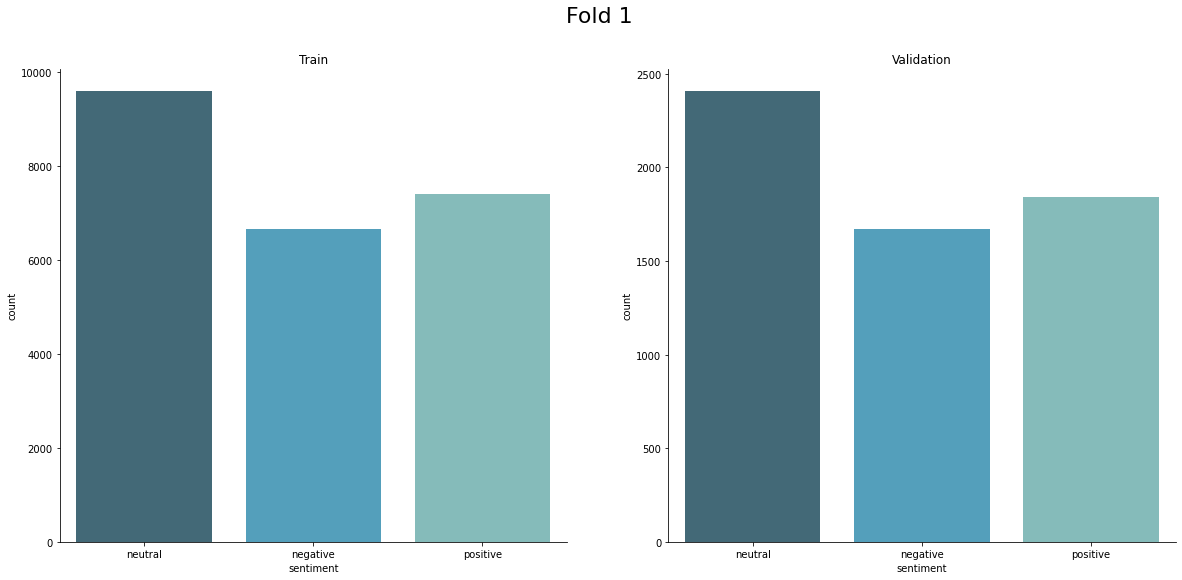

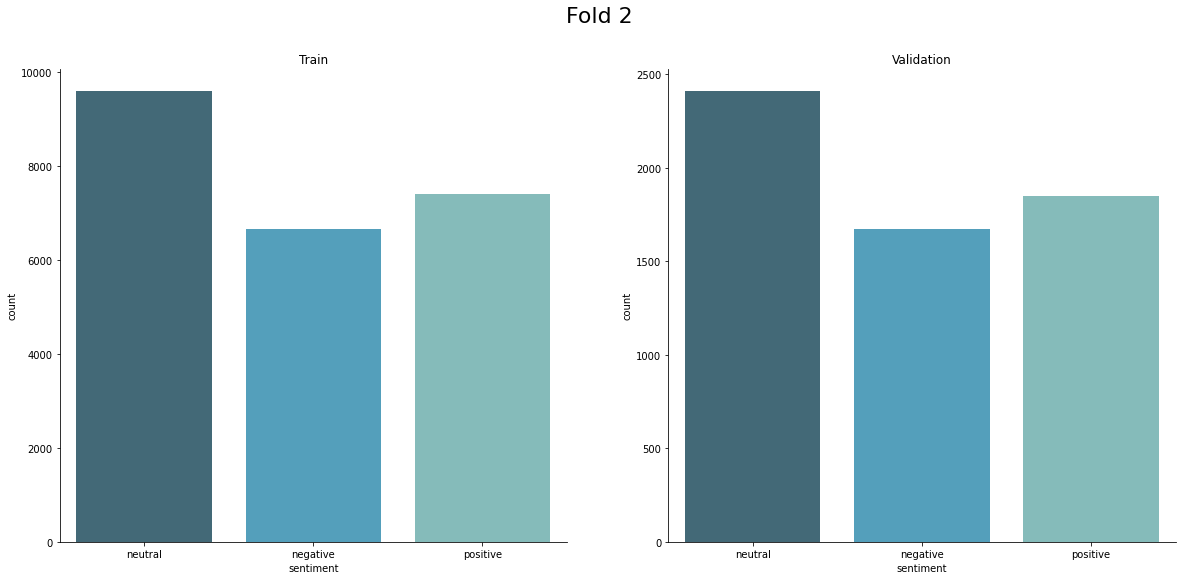

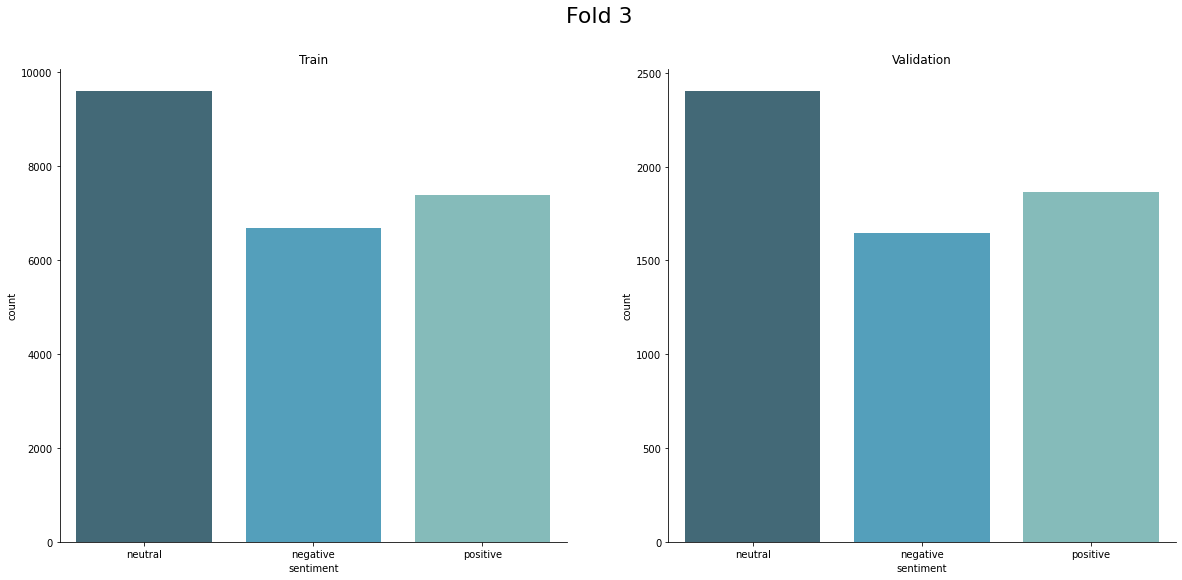

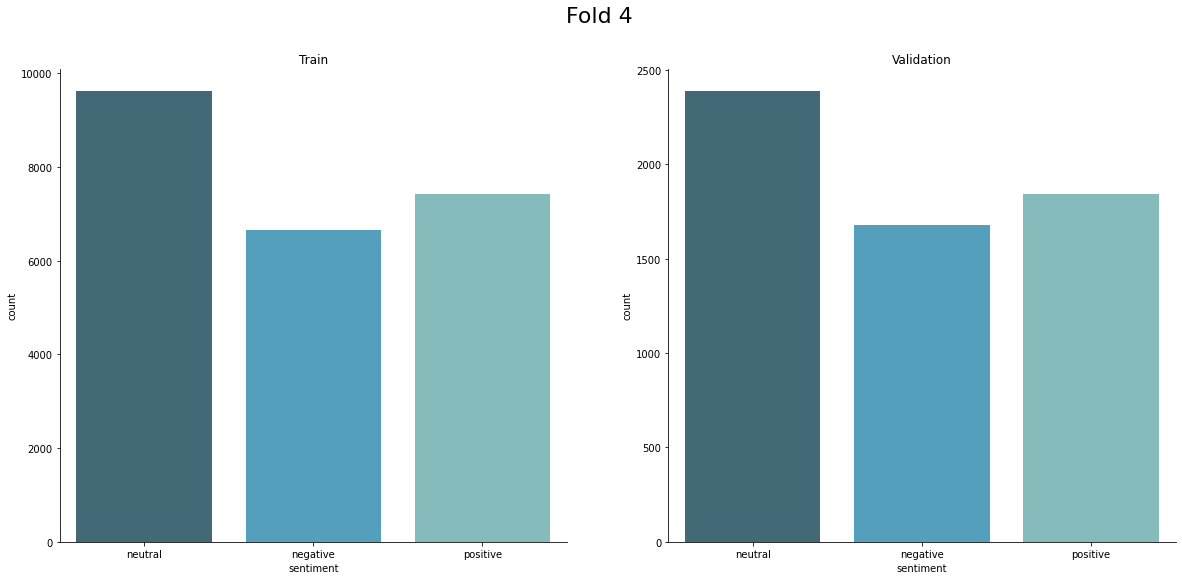

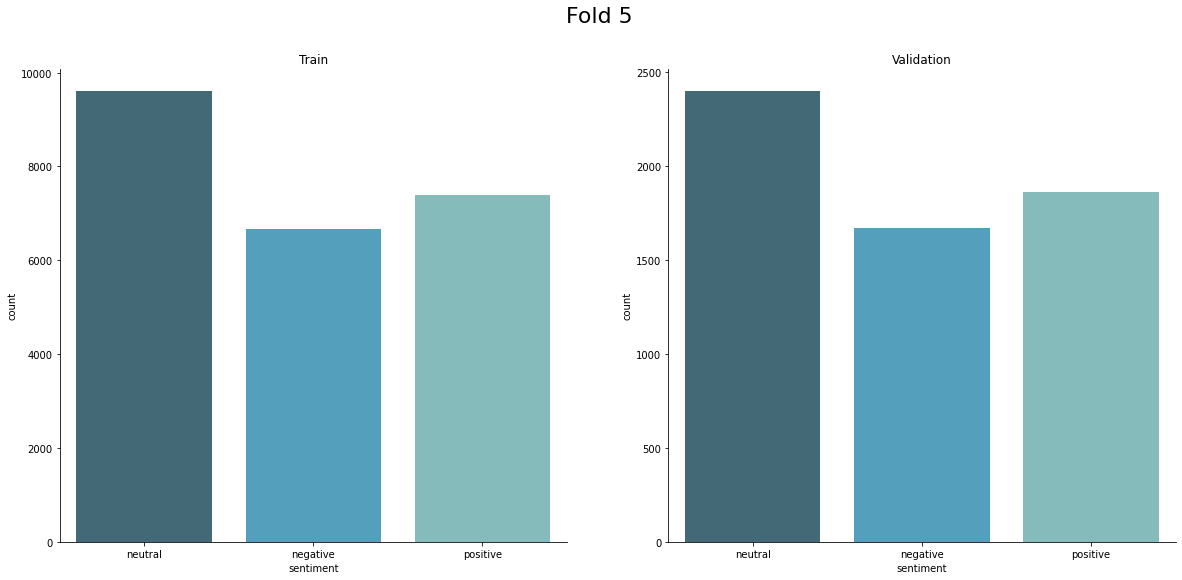

In [9]:
for fold_n in range(folds.n_splits):
    fold_n += 1
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8.7))
    fig.suptitle('Fold %s' % fold_n, fontsize=22)    
    sns.countplot(x="sentiment", data=train_df[train_df[('fold_%s' % fold_n)] == 'train'], palette="GnBu_d", order=sentiment_cols, ax=ax1).set_title('Train')
    sns.countplot(x="sentiment", data=train_df[train_df[('fold_%s' % fold_n)] == 'validation'], palette="GnBu_d", order=sentiment_cols, ax=ax2).set_title('Validation')
    sns.despine()
    plt.show()

## Word count distribution

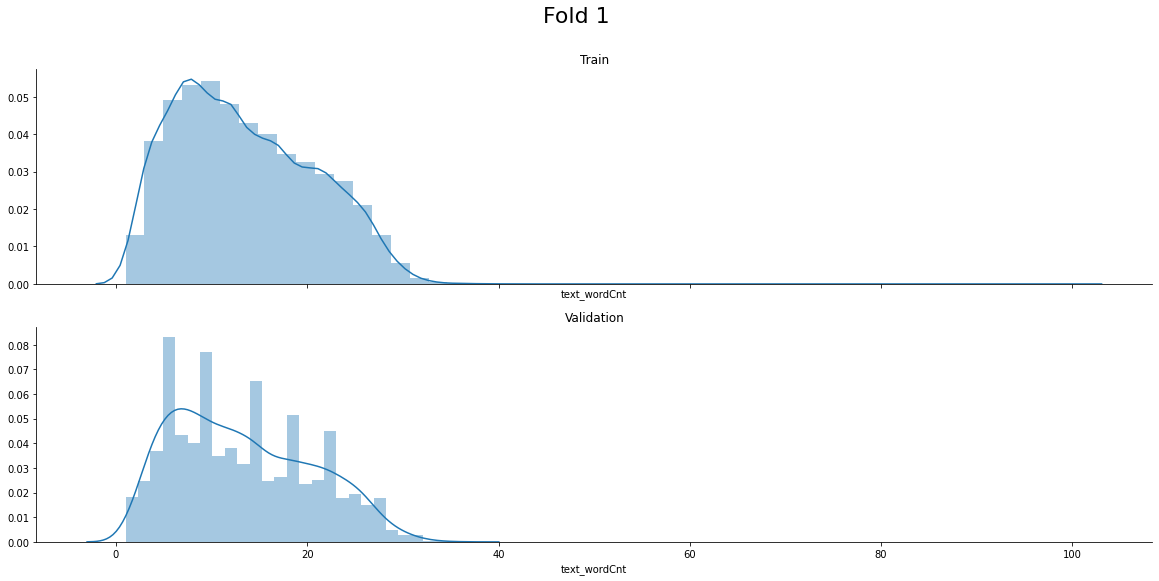

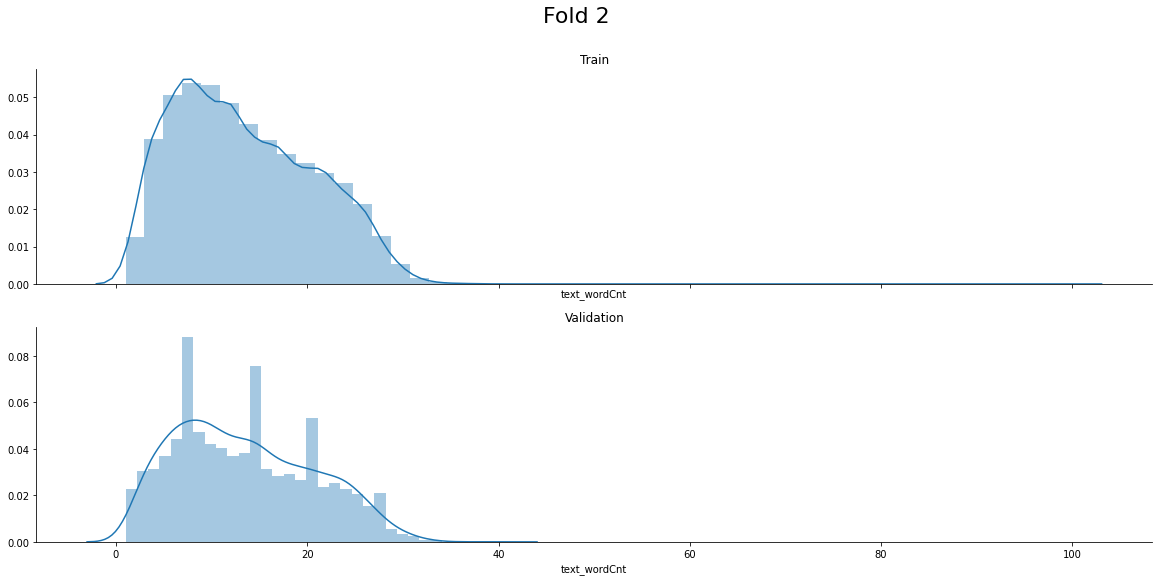

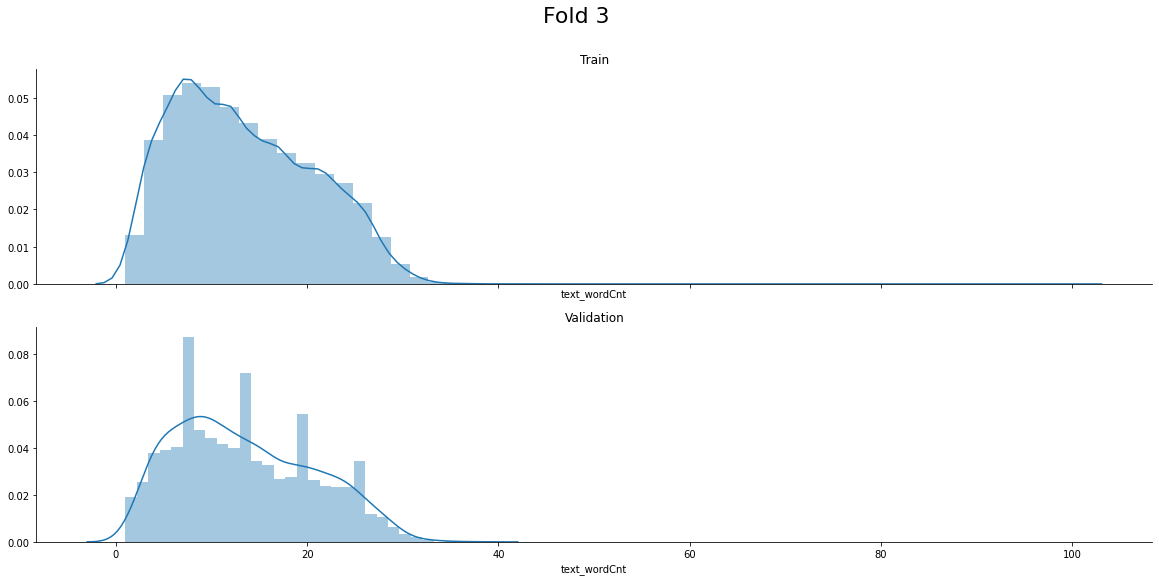

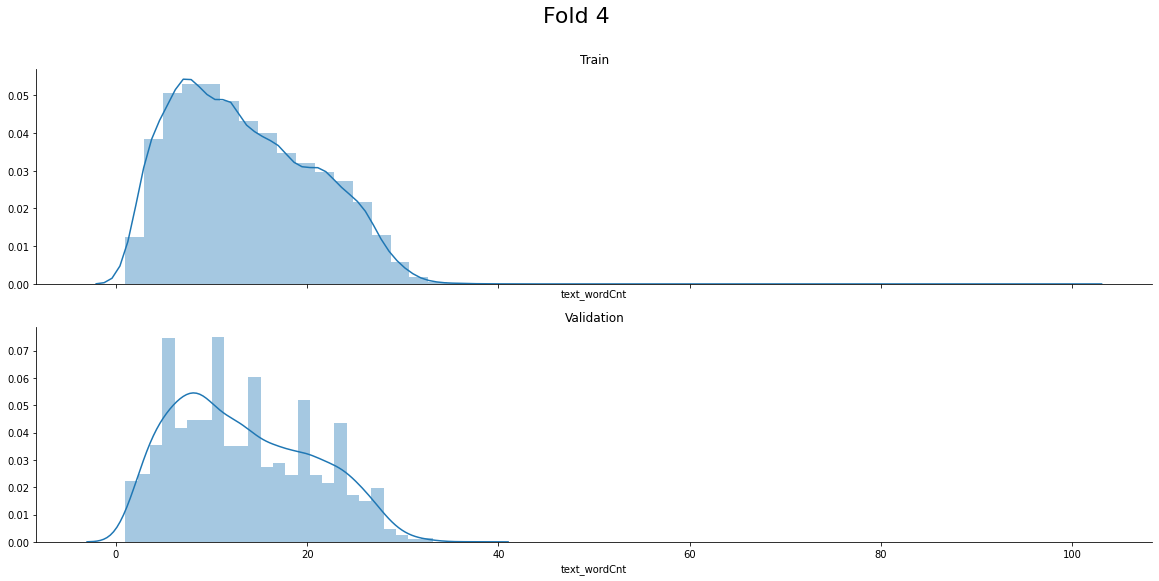

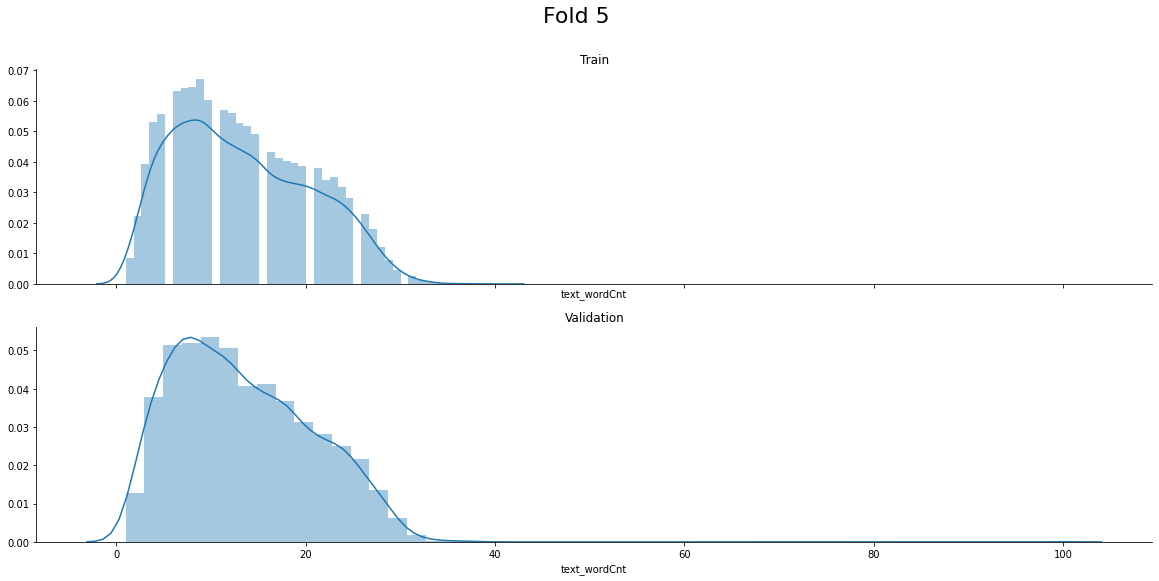

In [10]:
for fold_n in range(folds.n_splits):
    fold_n += 1
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8.7), sharex=True)
    fig.suptitle('Fold %s' % fold_n, fontsize=22)
    sns.distplot(train_df[train_df[('fold_%s' % fold_n)] == 'train']['text_wordCnt'], ax=ax1).set_title("Train")
    sns.distplot(train_df[train_df[('fold_%s' % fold_n)] == 'validation']['text_wordCnt'], ax=ax2).set_title("Validation")
    sns.despine()
    plt.show()

# Output 5-fold set

In [11]:
train_df.to_csv('5-fold.csv', index=False)
display(train_df.head())

for fold_n in range(folds.n_splits):
    fold_n += 1
    
    base_path = 'fold_%d/' % fold_n
    # Create dir
    os.makedirs(base_path)
    
    x_train, x_train_aux, x_train_aux_2, y_train, y_train_mask, y_train_aux = get_data(train_df[train_df[('fold_%s' % fold_n)] == 'train'], tokenizer, 
                                                                                       MAX_LEN, preprocess_fn=preprocess_roberta)
    x_valid, x_valid_aux, x_valid_aux_2, y_valid, y_valid_mask, y_valid_aux = get_data(train_df[(train_df[('fold_%s' % fold_n)] == 'validation') & 
                                                                                                (train_df['imputed'] == False)], tokenizer, 
                                                                                       MAX_LEN, preprocess_fn=preprocess_roberta)
    
    x_train, x_train_aux, x_train_aux_2 = np.array(x_train), np.array(x_train_aux), np.array(x_train_aux_2)
    y_train, y_train_mask, y_train_aux = np.array(y_train), np.array(y_train_mask), np.array(y_train_aux)
    x_valid, x_valid_aux, x_valid_aux_2 = np.array(x_valid), np.array(x_valid_aux), np.array(x_valid_aux_2)
    y_valid, y_valid_mask, y_valid_aux = np.array(y_valid), np.array(y_valid_mask), np.array(y_valid_aux)
    
    print('\nFOLD: %d' % (fold_n))
    print('x_train, y_train', x_train.shape, y_train.shape)
    print('x_valid, y_valid', x_valid.shape, y_valid.shape)
    print('x_train_aux, y_train_aux, x_train_aux_2', x_train_aux.shape, y_train_aux.shape, x_train_aux_2.shape)
    print('x_valid_aux, y_valid_aux, x_valid_aux_2', x_valid_aux.shape, y_valid_aux.shape, x_valid_aux_2.shape)
    print('y_train_mask', y_train_mask.shape)
    print('y_valid_mask', y_valid_mask.shape)
    
    np.save(base_path + 'x_train', x_train)
    np.save(base_path + 'y_train', y_train)
    np.save(base_path + 'x_valid', x_valid)
    np.save(base_path + 'y_valid', y_valid)
    np.save(base_path + 'x_train_aux', x_train_aux)
    np.save(base_path + 'x_train_aux_2', x_train_aux_2)
    np.save(base_path + 'y_train_mask', y_train_mask)
    np.save(base_path + 'y_train_aux', y_train_aux)
    np.save(base_path + 'x_valid_aux', x_valid_aux)
    np.save(base_path + 'x_valid_aux_2', x_valid_aux_2)
    np.save(base_path + 'y_valid_mask', y_valid_mask)
    np.save(base_path + 'y_valid_aux', y_valid_aux)
    
#  Compress logs dir
!tar -czf fold_1.tar.gz fold_1
!tar -czf fold_2.tar.gz fold_2
!tar -czf fold_3.tar.gz fold_3
!tar -czf fold_4.tar.gz fold_4
!tar -czf fold_5.tar.gz fold_5

# Delete logs dir
shutil.rmtree('fold_1')
shutil.rmtree('fold_2')
shutil.rmtree('fold_3')
shutil.rmtree('fold_4')
shutil.rmtree('fold_5')

,textID,text,selected_text,sentiment,fold_1,fold_2,fold_3,fold_4,fold_5,imputed,jaccard,text_len,text_wordCnt,text_tokenCnt,selected_text_len,selected_text_wordCnt,selected_text_tokenCnt
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,train,train,train,validation,train,False,1.000000,35,7,10,35,7,10
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative,validation,train,train,train,train,False,0.200000,45,10,13,8,2,3
2,088c60f138,my boss is bullying me...,bullying me,negative,train,validation,train,train,train,False,0.166667,25,5,6,11,2,2
3,9642c003ef,what interview! leave me alone,leave me alone,negative,train,validation,train,train,train,False,0.600000,30,5,6,14,3,3
4,358bd9e861,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,train,train,validation,train,train,False,0.214286,74,14,17,13,3,4



FOLD: 1
x_train, y_train (2, 23674, 96) (2, 23674, 96)
x_valid, y_valid (2, 5496, 96) (2, 5496, 96)
x_train_aux, y_train_aux, x_train_aux_2 (1, 23674) (3, 23674) (23674, 3)
x_valid_aux, y_valid_aux, x_valid_aux_2 (1, 5496) (3, 5496) (5496, 3)
y_train_mask (23674, 96)
y_valid_mask (5496, 96)

FOLD: 2
x_train, y_train (2, 23664, 96) (2, 23664, 96)
x_valid, y_valid (2, 5496, 96) (2, 5496, 96)
x_train_aux, y_train_aux, x_train_aux_2 (1, 23664) (3, 23664) (23664, 3)
x_valid_aux, y_valid_aux, x_valid_aux_2 (1, 5496) (3, 5496) (5496, 3)
y_train_mask (23664, 96)
y_valid_mask (5496, 96)

FOLD: 3
x_train, y_train (2, 23679, 96) (2, 23679, 96)
x_valid, y_valid (2, 5496, 96) (2, 5496, 96)
x_train_aux, y_train_aux, x_train_aux_2 (1, 23679) (3, 23679) (23679, 3)
x_valid_aux, y_valid_aux, x_valid_aux_2 (1, 5496) (3, 5496) (5496, 3)
y_train_mask (23679, 96)
y_valid_mask (5496, 96)

FOLD: 4
x_train, y_train (2, 23685, 96) (2, 23685, 96)
x_valid, y_valid (2, 5496, 96) (2, 5496, 96)
x_train_aux, y_train

# Output 5-fold set (balanced)

In [12]:
for fold_n in range(folds.n_splits):
    fold_n += 1
    
    base_path = 'balanced_fold_%d/' % fold_n
    # Create dir
    os.makedirs(base_path)
    
    
    train_fold = train_df[train_df[('fold_%s' % fold_n)] == 'train'].copy()
    valid_fold = train_df[(train_df[('fold_%s' % fold_n)] == 'validation') & (train_df['imputed'] == False)].copy()
    
    # Sample data by lower bound
    lower_count_train = min(len(train_fold[train_fold['sentiment'] == 'neutral']), 
                            len(train_fold[train_fold['sentiment'] == 'negative']), 
                            len(train_fold[train_fold['sentiment'] == 'positive']))
    lower_count_valid = min(len(valid_fold[valid_fold['sentiment'] == 'neutral']), 
                            len(valid_fold[valid_fold['sentiment'] == 'negative']), 
                            len(valid_fold[valid_fold['sentiment'] == 'positive']))

    train_fold = pd.concat([train_fold[train_fold['sentiment'] == 'neutral'].sample(n=lower_count_train, random_state=SEED),
                            train_fold[train_fold['sentiment'] == 'negative'].sample(n=lower_count_train, random_state=SEED),
                            train_fold[train_fold['sentiment'] == 'positive'].sample(n=lower_count_train, random_state=SEED),
                           ])
    valid_fold = pd.concat([valid_fold[valid_fold['sentiment'] == 'neutral'].sample(n=lower_count_valid, random_state=SEED),
                            valid_fold[valid_fold['sentiment'] == 'negative'].sample(n=lower_count_valid, random_state=SEED),
                            valid_fold[valid_fold['sentiment'] == 'positive'].sample(n=lower_count_valid, random_state=SEED),
                           ])
    
    train_fold = shuffle(train_fold, random_state=SEED).reset_index(drop=True)
    valid_fold = shuffle(valid_fold, random_state=SEED).reset_index(drop=True)
    
    
    x_train, x_train_aux, x_train_aux_2, y_train, y_train_mask, y_train_aux = get_data(train_fold, tokenizer, MAX_LEN, preprocess_fn=preprocess_roberta)
    x_valid, x_valid_aux, x_valid_aux_2, y_valid, y_valid_mask, y_valid_aux = get_data(valid_fold, tokenizer, MAX_LEN, preprocess_fn=preprocess_roberta)
    
    x_train, x_train_aux, x_train_aux_2 = np.array(x_train), np.array(x_train_aux), np.array(x_train_aux_2)
    y_train, y_train_mask, y_train_aux = np.array(y_train), np.array(y_train_mask), np.array(y_train_aux)
    x_valid, x_valid_aux, x_valid_aux_2 = np.array(x_valid), np.array(x_valid_aux), np.array(x_valid_aux_2)
    y_valid, y_valid_mask, y_valid_aux = np.array(y_valid), np.array(y_valid_mask), np.array(y_valid_aux)
    
    
    print('\nFOLD: %d' % (fold_n))
    print('x_train, y_train', x_train.shape, y_train.shape)
    print('x_valid, y_valid', x_valid.shape, y_valid.shape)
    print('x_train_aux, y_train_aux, x_train_aux_2', x_train_aux.shape, y_train_aux.shape, x_train_aux_2.shape)
    print('x_valid_aux, y_valid_aux, x_valid_aux_2', x_valid_aux.shape, y_valid_aux.shape, x_valid_aux_2.shape)
    print('y_train_mask', y_train_mask.shape)
    print('y_valid_mask', y_valid_mask.shape)
    
    np.save(base_path + 'x_train', x_train)
    np.save(base_path + 'y_train', y_train)
    np.save(base_path + 'x_valid', x_valid)
    np.save(base_path + 'y_valid', y_valid)
    np.save(base_path + 'x_train_aux', x_train_aux)
    np.save(base_path + 'x_train_aux_2', x_train_aux_2)
    np.save(base_path + 'y_train_mask', y_train_mask)
    np.save(base_path + 'y_train_aux', y_train_aux)
    np.save(base_path + 'x_valid_aux', x_valid_aux)
    np.save(base_path + 'x_valid_aux_2', x_valid_aux_2)
    np.save(base_path + 'y_valid_mask', y_valid_mask)
    np.save(base_path + 'y_valid_aux', y_valid_aux)
    
#  Compress logs dir
!tar -czf balanced_fold_1.tar.gz balanced_fold_1
!tar -czf balanced_fold_2.tar.gz balanced_fold_2
!tar -czf balanced_fold_3.tar.gz balanced_fold_3
!tar -czf balanced_fold_4.tar.gz balanced_fold_4
!tar -czf balanced_fold_5.tar.gz balanced_fold_5

# Delete logs dir
shutil.rmtree('balanced_fold_1')
shutil.rmtree('balanced_fold_2')
shutil.rmtree('balanced_fold_3')
shutil.rmtree('balanced_fold_4')
shutil.rmtree('balanced_fold_5')


FOLD: 1
x_train, y_train (2, 20007, 96) (2, 20007, 96)
x_valid, y_valid (2, 4668, 96) (2, 4668, 96)
x_train_aux, y_train_aux, x_train_aux_2 (1, 20007) (3, 20007) (20007, 3)
x_valid_aux, y_valid_aux, x_valid_aux_2 (1, 4668) (3, 4668) (4668, 3)
y_train_mask (20007, 96)
y_valid_mask (4668, 96)

FOLD: 2
x_train, y_train (2, 20007, 96) (2, 20007, 96)
x_valid, y_valid (2, 4668, 96) (2, 4668, 96)
x_train_aux, y_train_aux, x_train_aux_2 (1, 20007) (3, 20007) (20007, 3)
x_valid_aux, y_valid_aux, x_valid_aux_2 (1, 4668) (3, 4668) (4668, 3)
y_train_mask (20007, 96)
y_valid_mask (4668, 96)

FOLD: 3
x_train, y_train (2, 20076, 96) (2, 20076, 96)
x_valid, y_valid (2, 4671, 96) (2, 4671, 96)
x_train_aux, y_train_aux, x_train_aux_2 (1, 20076) (3, 20076) (20076, 3)
x_valid_aux, y_valid_aux, x_valid_aux_2 (1, 4671) (3, 4671) (4671, 3)
y_train_mask (20076, 96)
y_valid_mask (4671, 96)

FOLD: 4
x_train, y_train (2, 19983, 96) (2, 19983, 96)
x_valid, y_valid (2, 4668, 96) (2, 4668, 96)
x_train_aux, y_train

## Tokenizer sanity check (no QA)

In [13]:
for idx in range(5):
    print('\nRow %d' % idx)
    max_seq_len = 32
    text = train_df['text'].values[idx]
    selected_text = train_df['selected_text'].values[idx]
    
    _,  (target_start, target_end, _) = preprocess_text.preprocess_roberta(' ' + text, selected_text, tokenizer, max_seq_len)
    
    decoded_text = preprocess_text.decode(target_start.argmax(), target_end.argmax(), text, tokenizer)
    
    print('text         : "%s"' % text)
    print('selected_text: "%s"' % selected_text)
    print('decoded_text : "%s"' % decoded_text)
    
    assert selected_text == decoded_text


Row 0
text         : "i`d have responded, if i were going"
selected_text: "i`d have responded, if i were going"
decoded_text : "i`d have responded, if i were going"

Row 1
text         : "sooo sad i will miss you here in san diego!!!"
selected_text: "sooo sad"
decoded_text : "sooo sad"

Row 2
text         : "my boss is bullying me..."
selected_text: "bullying me"
decoded_text : "bullying me"

Row 3
text         : "what interview! leave me alone"
selected_text: "leave me alone"
decoded_text : "leave me alone"

Row 4
text         : "sons of ****, why couldn`t they put them on the releases we already bought"
selected_text: "sons of ****,"
decoded_text : "sons of ****,"


## Data generation sanity check (no QA)

In [14]:
for idx in range(5):
    print('\nRow %d' % idx)
    max_seq_len = 24
    text = train_df['text'].values[idx]
    selected_text = train_df['selected_text'].values[idx]
    jaccard = train_df['jaccard'].values[idx]
    selected_text_wordCnt = train_df['selected_text_wordCnt'].values[idx]
    
    x_train, x_train_aux, x_train_aux_2, y_train, y_train_mask, y_train_aux = preprocess_text.get_data(train_df[idx:idx+1], tokenizer, max_seq_len, 
                                                                                                       preprocess_fn=preprocess_text.preprocess_roberta)
    
    print('text          : "%s"'   % text)
    print('jaccard       : "%.4f"' % jaccard)
    print('sentiment     : "%s"'   % question)
    print('word count    : "%d"'   % selected_text_wordCnt)
    
    print('input_ids     : "%s"'   % x_train[0][0])
    print('attention_mask: "%s"'   % x_train[1][0])
    print('sentiment     : "%d"'   % x_train_aux[0])
    print('sentiment OHE : "%s"'   % x_train_aux_2[0])
    
    print('selected_text : "%s"'   % selected_text)
    print('start         : "%s"'   % y_train[0][0])
    print('end           : "%s"'   % y_train[1][0])
    print('mask          : "%s"'   % y_train_mask[0])
    print('jaccard       : "%.4f"' % y_train_aux[0][0])
    print('word count    : "%d"'   % y_train_aux[1][0])
    
    assert len(x_train) == 2
    assert len(x_train_aux) == 1
    assert len(x_train_aux_2) == 1
    assert len(y_train) == 2
    assert len(y_train_mask) == 1
    assert len(y_train_aux) == 3
    
    assert len(x_train[0][0]) == len(x_train[1][0]) == max_seq_len
    assert len(y_train[0][0]) == len(y_train[1][0]) == len(y_train_mask[0]) == max_seq_len


Row 0
text          : "i`d have responded, if i were going"
jaccard       : "1.0000"
sentiment     : "negative"
word count    : "7"
input_ids     : "[  939 12905   417    33  2334     6   114   939    58   164     1     1
     1     1     1     1     1     1     1     1     1     1     1     1]"
attention_mask: "[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]"
sentiment     : "1"
sentiment OHE : "[0 1 0]"
selected_text : "i`d have responded, if i were going"
start         : "[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]"
end           : "[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]"
mask          : "[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]"
jaccard       : "1.0000"
word count    : "7"

Row 1
text          : "sooo sad i will miss you here in san diego!!!"
jaccard       : "0.2000"
sentiment     : "negative"
word count    : "2"
input_ids     : "[   98  3036  5074   939    40  2649    47   259    11 15610  1597  2977
 16506     1     1     1     1     1     1     1    

# Output 5-fold set (no QA)

In [15]:
for fold_n in range(folds.n_splits):
    fold_n += 1
    
    base_path = 'no_qa_fold_%d/' % fold_n
    # Create dir
    os.makedirs(base_path)
    
    x_train, x_train_aux, x_train_aux_2, y_train, y_train_mask, y_train_aux = preprocess_text.get_data(train_df[train_df[('fold_%s' % fold_n)] == 'train'], tokenizer, 
                                                                                                       MAX_LEN, preprocess_fn=preprocess_text.preprocess_roberta)
    x_valid, x_valid_aux, x_valid_aux_2, y_valid, y_valid_mask, y_valid_aux = preprocess_text.get_data(train_df[(train_df[('fold_%s' % fold_n)] == 'validation') & 
                                                                                                                (train_df['imputed'] == False)], tokenizer, 
                                                                                                       MAX_LEN, preprocess_fn=preprocess_text.preprocess_roberta)
    
    x_train, x_train_aux, x_train_aux_2 = np.array(x_train), np.array(x_train_aux), np.array(x_train_aux_2)
    y_train, y_train_mask, y_train_aux = np.array(y_train), np.array(y_train_mask), np.array(y_train_aux)
    x_valid, x_valid_aux, x_valid_aux_2 = np.array(x_valid), np.array(x_valid_aux), np.array(x_valid_aux_2)
    y_valid, y_valid_mask, y_valid_aux = np.array(y_valid), np.array(y_valid_mask), np.array(y_valid_aux)
    
    print('\nFOLD: %d' % (fold_n))
    print('x_train, y_train', x_train.shape, y_train.shape)
    print('x_valid, y_valid', x_valid.shape, y_valid.shape)
    print('x_train_aux, y_train_aux, x_train_aux_2', x_train_aux.shape, y_train_aux.shape, x_train_aux_2.shape)
    print('x_valid_aux, y_valid_aux, x_valid_aux_2', x_valid_aux.shape, y_valid_aux.shape, x_valid_aux_2.shape)
    print('y_train_mask', y_train_mask.shape)
    print('y_valid_mask', y_valid_mask.shape)
    
    np.save(base_path + 'x_train', x_train)
    np.save(base_path + 'y_train', y_train)
    np.save(base_path + 'x_valid', x_valid)
    np.save(base_path + 'y_valid', y_valid)
    np.save(base_path + 'x_train_aux', x_train_aux)
    np.save(base_path + 'x_train_aux_2', x_train_aux_2)
    np.save(base_path + 'y_train_mask', y_train_mask)
    np.save(base_path + 'y_train_aux', y_train_aux)
    np.save(base_path + 'x_valid_aux', x_valid_aux)
    np.save(base_path + 'x_valid_aux_2', x_valid_aux_2)
    np.save(base_path + 'y_valid_mask', y_valid_mask)
    np.save(base_path + 'y_valid_aux', y_valid_aux)
    
#  Compress logs dir
!tar -czf no_qa_fold_1.tar.gz no_qa_fold_1
!tar -czf no_qa_fold_2.tar.gz no_qa_fold_2
!tar -czf no_qa_fold_3.tar.gz no_qa_fold_3
!tar -czf no_qa_fold_4.tar.gz no_qa_fold_4
!tar -czf no_qa_fold_5.tar.gz no_qa_fold_5

# Delete logs dir
shutil.rmtree('no_qa_fold_1')
shutil.rmtree('no_qa_fold_2')
shutil.rmtree('no_qa_fold_3')
shutil.rmtree('no_qa_fold_4')
shutil.rmtree('no_qa_fold_5')


FOLD: 1
x_train, y_train (2, 23674, 96) (2, 23674, 96)
x_valid, y_valid (2, 5496, 96) (2, 5496, 96)
x_train_aux, y_train_aux, x_train_aux_2 (1, 23674) (3, 23674) (23674, 3)
x_valid_aux, y_valid_aux, x_valid_aux_2 (1, 5496) (3, 5496) (5496, 3)
y_train_mask (23674, 96)
y_valid_mask (5496, 96)

FOLD: 2
x_train, y_train (2, 23664, 96) (2, 23664, 96)
x_valid, y_valid (2, 5496, 96) (2, 5496, 96)
x_train_aux, y_train_aux, x_train_aux_2 (1, 23664) (3, 23664) (23664, 3)
x_valid_aux, y_valid_aux, x_valid_aux_2 (1, 5496) (3, 5496) (5496, 3)
y_train_mask (23664, 96)
y_valid_mask (5496, 96)

FOLD: 3
x_train, y_train (2, 23679, 96) (2, 23679, 96)
x_valid, y_valid (2, 5496, 96) (2, 5496, 96)
x_train_aux, y_train_aux, x_train_aux_2 (1, 23679) (3, 23679) (23679, 3)
x_valid_aux, y_valid_aux, x_valid_aux_2 (1, 5496) (3, 5496) (5496, 3)
y_train_mask (23679, 96)
y_valid_mask (5496, 96)

FOLD: 4
x_train, y_train (2, 23685, 96) (2, 23685, 96)
x_valid, y_valid (2, 5496, 96) (2, 5496, 96)
x_train_aux, y_train

# Test set EDA

In [16]:
test_df = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/test.csv')

# pre-process
test_df["text"] = test_df["text"].apply(lambda x: x.strip())
test_df["text"] = test_df["text"].apply(lambda x: x.lower())
test_df['text_len'] = test_df['text'].apply(lambda x : len(x))
test_df['text_wordCnt'] = test_df['text'].apply(lambda x : len(x.split(' ')))
test_df['text_tokenCnt'] = test_df['text'].apply(lambda x : len(tokenizer.encode(x).ids))

print('Test samples: %s' % len(test_df))
display(test_df.head())
display(test_df.describe())

Test samples: 3534


,textID,text,sentiment,text_len,text_wordCnt,text_tokenCnt
0,f87dea47db,last session of the day http://twitpic.com/67ezh,neutral,49,7,17
1,96d74cb729,shanghai is also really exciting (precisely --...,positive,102,17,33
2,eee518ae67,"recession hit veronique branquinho, she has to...",negative,78,13,20
3,01082688c6,happy bday!,positive,11,2,4
4,33987a8ee5,http://twitpic.com/4w75p - i like it!!,positive,38,5,17


,text_len,text_wordCnt,text_tokenCnt
count,3534.000000,3534.000000,3534.000000
mean,67.326259,13.185059,18.197510
std,35.609555,7.113988,9.808701
min,3.000000,1.000000,1.000000
25%,38.000000,7.000000,10.000000
50%,62.000000,12.000000,17.000000
75%,96.000000,19.000000,26.000000
max,142.000000,35.000000,68.000000


## Sentiment distribution

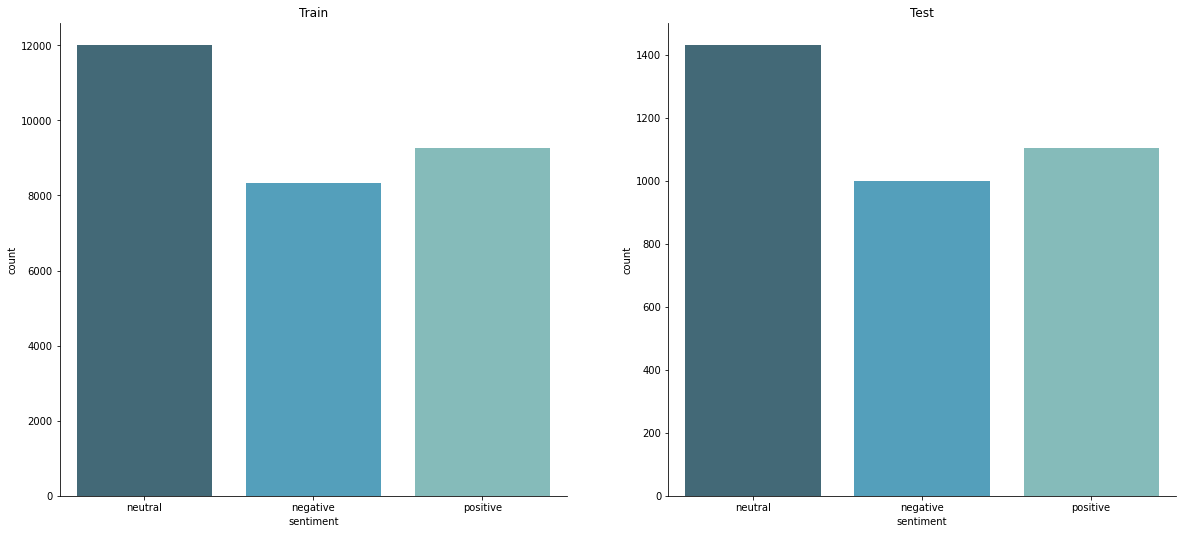

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8.7))
sns.countplot(x="sentiment", data=train_df, palette="GnBu_d", order=sentiment_cols, ax=ax1).set_title('Train')
sns.countplot(x="sentiment", data=test_df, palette="GnBu_d", order=sentiment_cols, ax=ax2).set_title('Test')
sns.despine()
plt.show()

## Word count distribution

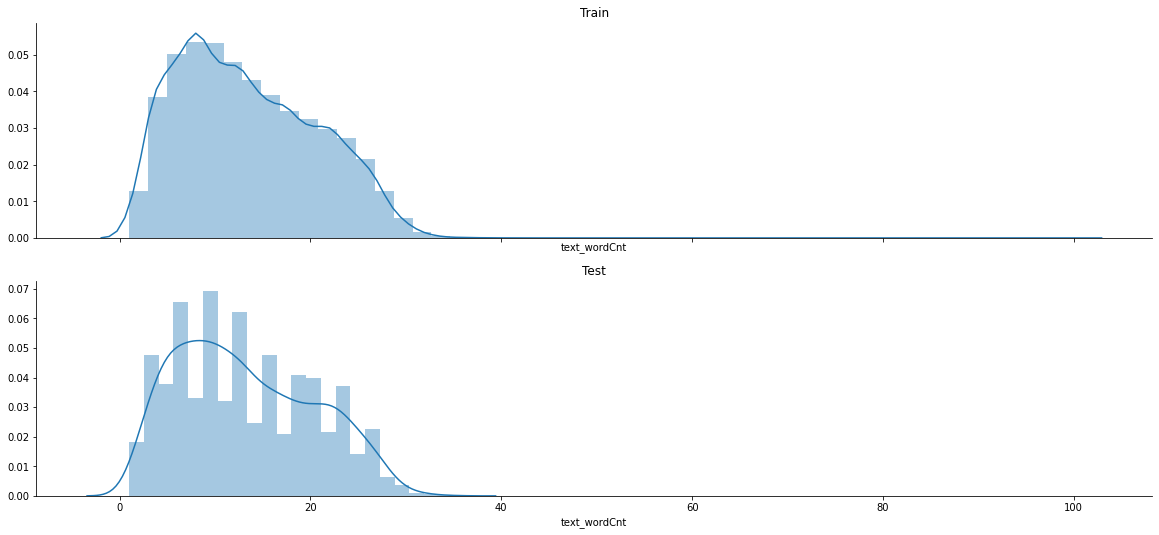

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8.7), sharex=True)
sns.distplot(train_df['text_wordCnt'], ax=ax1).set_title("Train")
sns.distplot(test_df['text_wordCnt'], ax=ax2).set_title("Test")
sns.despine()
plt.show()

## Token count distribution

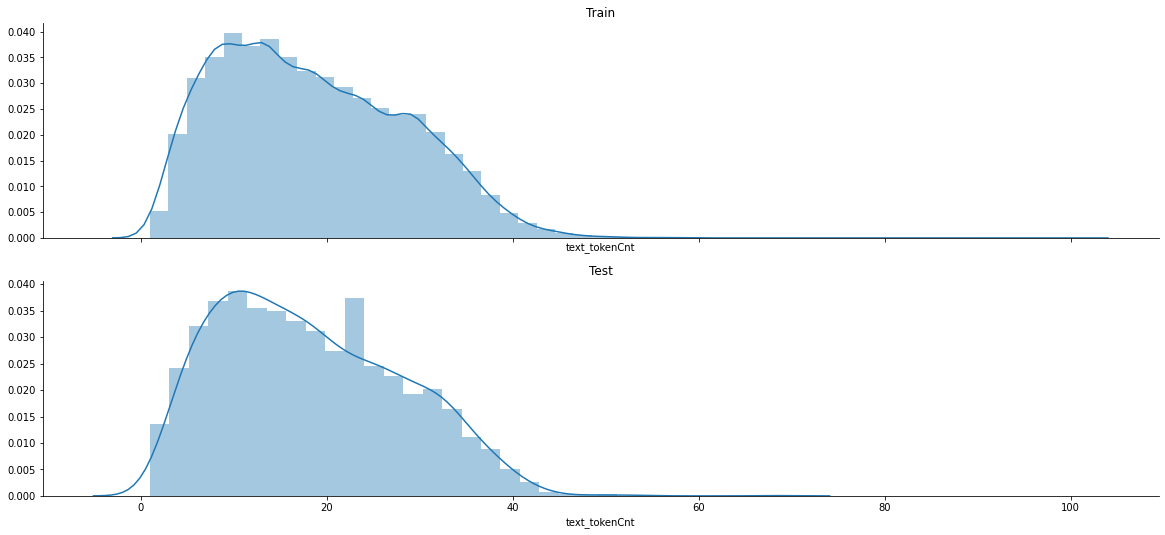

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8.7), sharex=True)
sns.distplot(train_df['text_tokenCnt'], ax=ax1).set_title("Train")
sns.distplot(test_df['text_tokenCnt'], ax=ax2).set_title("Test")
sns.despine()
plt.show()